# Integrantes do grupo

1. **Nome(s):** Eder Oliveira Dias, Pedro Henrique de Castro Cunha Quedevez, Renan Campista, Ricardo Modenese Ramalho

2. **Curso(s):** Ciência da Computação, Ciência da Computação, Ciência da Computação, Ciência da Computação

# Apresentação do Problema da Localização das Instalações (Facility Location Problem)

## 1. Introdução

O Problema da Localização das Instalações (Facility Location Problem - FLP) é uma das aplicações clássicas de programação linear inteira mista (MILP). Ele busca determinar onde abrir instalações (como fábricas, armazéns, hospitais) para atender de forma eficiente a uma demanda dispersa geograficamente, minimizando os custos operacionais e de transporte.

Vamos inicialmente considerar uma versão simples do problema chamada Problema da Localização de Instalações Não Capacitado (Uncapacitated Facility Location Problem - UFLP).

## 2. Versão Simples (UFLP)

Neste modelo simples:

- Existem `m` instalações candidatas com custo fixo de abertura.

- Existem `n` clientes com demandas.

- O custo de atender um cliente `j` a partir da instalação `i` é conhecido.

- Toda instalação pode atender qualquer número de clientes.

\begin{align*}
\text{Minimize:} \quad & \sum_{i=1}^{m} f_i y_i + \sum_{i=1}^{m} \sum_{j=1}^{n} c_{ij} x_{ij} \\
\text{Subject to:} \quad
& \sum_{i=1}^{m} x_{ij} = 1 \quad \forall j = 1, \dots, n \\
& x_{ij} \le y_i \quad \forall i = 1, \dots, m; \forall j = 1, \dots, n \\
& y_i \in \{0,1\} \quad \forall i = 1, \dots, m \\
& x_{ij} \in \{0,1\} \quad \forall i = 1, \dots, m; \forall j = 1, \dots, n
\end{align*}


Onde:

- `y_i = 1` se a instalação `i` for aberta.

- `x_ij = 1` se o cliente `j` for atendido pela instalação `i`.

## 3. Modelo AMPL

```ampl
set I;  # Instalações
set J;  # Clientes

param f {I};       # Custo fixo da instalação
param c {I, J};    # Custo de atendimento

var y {i in I} binary;
var x {i in I, j in J} binary;

minimize Total_Cost:
    sum {i in I} f[i] * y[i] +
    sum {i in I, j in J} c[i,j] * x[i,j];

subject to Demand {j in J}:
    sum {i in I} x[i,j] = 1;

subject to OpenIfUsed {i in I, j in J}:
    x[i,j] <= y[i];


## 4. Gerando Dados de Exemplo Automaticamente

In [ ]:
import pandas as pd
import numpy as np

# Definir parâmetros
num_inst = 7
num_cli = 10

np.random.seed(42)

# Gerar instalações
instalacoes_df = pd.DataFrame({
    'instalacao': [f'I{i}' for i in range(1, num_inst+1)],
    'custo_fixo': np.random.randint(80, 150, size=num_inst)
})

# Gerar clientes
clientes_df = pd.DataFrame({
    'cliente': [f'C{j}' for j in range(1, num_cli+1)]
})

# Gerar custos entre cada instalação e cliente
custos = []
for i in instalacoes_df['instalacao']:
    for j in clientes_df['cliente']:
        custo = np.random.randint(10, 100)
        custos.append({'instalacao': i, 'cliente': j, 'custo': custo})

custos_df = pd.DataFrame(custos)

# Salvar como CSV (útil no Colab para visualização e depuração)
instalacoes_df.to_csv('instalacoes.csv', index=False)
clientes_df.to_csv('clientes.csv', index=False)
custos_df.to_csv('custos.csv', index=False)

# Mostrar os DataFrames
print("Instalações:")
display(instalacoes_df)
print("Clientes:")
display(clientes_df)
print("Custos:")
display(custos_df)

Instalações:


,instalacao,custo_fixo
0,I1,131
1,I2,94
2,I3,140
3,I4,100
4,I5,103
5,I6,82
6,I7,101


Clientes:


,cliente
0,C1
1,C2
2,C3
3,C4
4,C5
5,C6
6,C7
7,C8
8,C9
9,C10


Custos:


,instalacao,cliente,custo
0,I1,C1,62
1,I1,C2,11
2,I1,C3,97
3,I1,C4,39
4,I1,C5,47
...,...,...,...
65,I7,C6,71
66,I7,C7,23
67,I7,C8,57
68,I7,C9,24


## 5. Solução com gurobipy

Instale a biblioteca gurobipy pelo comando abaixo:

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 43.4 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Ler os dados dos arquivos CSV gerados
inst = pd.read_csv("instalacoes.csv")
cli = pd.read_csv("clientes.csv")
custos = pd.read_csv("custos.csv")

I = inst['instalacao'].tolist()
J = cli['cliente'].tolist()
f = dict(zip(inst['instalacao'], inst['custo_fixo']))
c = {(row.instalacao, row.cliente): row.custo for row in custos.itertuples(index=False)}

# Criar modelo
m = gp.Model("FacilityLocation")

y = m.addVars(I, vtype=GRB.BINARY, name="y")
x = m.addVars(I, J, vtype=GRB.BINARY, name="x")

# Função objetivo
m.setObjective(
    gp.quicksum(f[i] * y[i] for i in I) +
    gp.quicksum(c[i, j] * x[i, j] for i in I for j in J),
    GRB.MINIMIZE
)

# Restrições
for j in J:
    m.addConstr(gp.quicksum(x[i, j] for i in I) == 1, name=f"Atendimento_{j}")

for i in I:
    for j in J:
        m.addConstr(x[i, j] <= y[i], name=f"AtendeSomenteSeAberta_{i}_{j}")

# Resolver
m.optimize()

# Mostrar resultados
if m.Status == GRB.OPTIMAL:
    print("\nInstalações abertas:")
    for i in I:
        if y[i].X > 0.5:
            print(f"- {i}")

    print("\nClientes atendidos:")
    for j in J:
        for i in I:
            if x[i, j].X > 0.5:
                print(f"{j} → {i}")


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 80 rows, 77 columns and 210 nonzeros
Model fingerprint: 0xc991cb42
Variable types: 0 continuous, 77 integer (77 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1089.0000000
Presolve time: 0.00s
Presolved: 80 rows, 77 columns, 210 nonzeros
Variable types: 0 continuous, 77 integer (77 binary)

Root relaxation: objective 4.790000e+02, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

## Visualização da solução

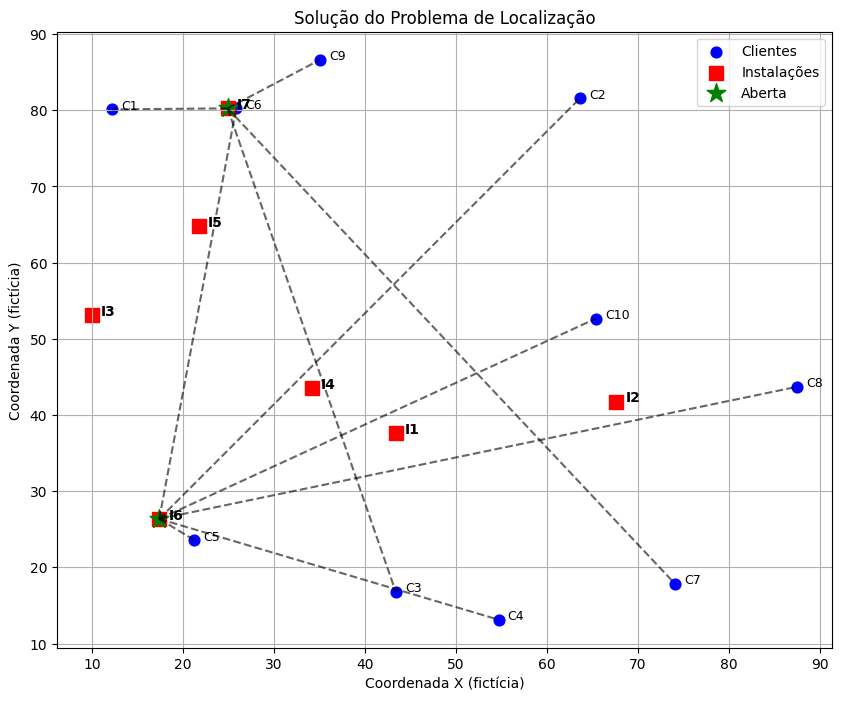

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recarregar dados dos arquivos CSV
inst = pd.read_csv("instalacoes.csv")
cli = pd.read_csv("clientes.csv")
custos = pd.read_csv("custos.csv")

I = inst['instalacao'].tolist()
J = cli['cliente'].tolist()

# Gerar posições fictícias para visualização
np.random.seed(1)
inst_coords = pd.DataFrame({
    'instalacao': I,
    'x': np.random.uniform(10, 90, len(I)),
    'y': np.random.uniform(10, 90, len(I))
})

cli_coords = pd.DataFrame({
    'cliente': J,
    'x': np.random.uniform(10, 90, len(J)),
    'y': np.random.uniform(10, 90, len(J))
})

# Plotar o gráfico da solução ótima
plt.figure(figsize=(10, 8))

# Clientes
plt.scatter(cli_coords['x'], cli_coords['y'], c='blue', label='Clientes', s=60)
for _, row in cli_coords.iterrows():
    plt.text(row['x'] + 1, row['y'], row['cliente'], fontsize=9)

# Instalações
plt.scatter(inst_coords['x'], inst_coords['y'], c='red', label='Instalações', s=100, marker='s')
for _, row in inst_coords.iterrows():
    plt.text(row['x'] + 1, row['y'], row['instalacao'], fontsize=10, weight='bold')

# Linhas de conexão com base na solução do modelo
for j in J:
    for i in I:
        if x[i, j].X > 0.5:
            xi = inst_coords.loc[inst_coords['instalacao'] == i, 'x'].values[0]
            yi = inst_coords.loc[inst_coords['instalacao'] == i, 'y'].values[0]
            xj = cli_coords.loc[cli_coords['cliente'] == j, 'x'].values[0]
            yj = cli_coords.loc[cli_coords['cliente'] == j, 'y'].values[0]
            plt.plot([xi, xj], [yi, yj], 'k--', alpha=0.6)

# Marcar instalações abertas
for i in I:
    if y[i].X > 0.5:
        xi = inst_coords.loc[inst_coords['instalacao'] == i, 'x'].values[0]
        yi = inst_coords.loc[inst_coords['instalacao'] == i, 'y'].values[0]
        plt.scatter(xi, yi, c='green', s=200, marker='*', label='Aberta' if 'Aberta' not in plt.gca().get_legend_handles_labels()[1] else "")

# Eixos e título
plt.title("Solução do Problema de Localização")
plt.xlabel("Coordenada X (fictícia)")
plt.ylabel("Coordenada Y (fictícia)")
plt.legend()
plt.grid(True)
plt.show()


# Artigo de Revisão: Dissanayake & Gunathilake (2024)

**Título:** [*A comprehensive survey of recent advances in facility location problems: Models, solution methods, and applications*](https://www.researchgate.net/publication/386201864_A_comprehensive_survey_of_recent_advances_in_facility_location_problems_Models_solution_methods_and_applications)

**Autores:** Ishan Dissanayake e Manishi Gunathilake  
**Publicado em:** *Journal of Sustainable Development of Transport and Logistics*, vol. 9, n.º 2, 2024 :contentReference[oaicite:0]{index=0}.

### Objetivos do estudo
- Realizar uma **revisão abrangente** dos avanços na modelagem e métodos de solução de problemas de localização de instalações (Facility Location Problems – FLPs).
- Cobrir um período recente, enfocando contribuições dos últimos dez anos.
- Classificar os trabalhos segundo variantes do problema, formulações matemáticas, métodos exatos e meta-heurísticas híbridas :contentReference.

### Principais contribuições
- **Classificação sistemática** das diversas variantes dos FLPs, incluindo modelos capacitados, não capacitados, medianas, centralidade e cobertura.
- Destaque para o amadurecimento dos métodos exatos (como programação matemática eficiente) e o surgimento de **meta-heurísticas híbridas**, que combinam robustez e escalabilidade.
- Identificação de **tendências emergentes**:
  - **Modelagem sob incerteza**: introdução de robustez e técnicas estocásticas para tomar decisões mais confiáveis em ambientes dinâmicos.
  - **Otimização multi-objetivo**: integração de objetivos além do custo monetário—como impacto ambiental, sustentabilidade e resiliência da cadeia.

Vamos pegar uma amostra de dados da [OR-Library](https://people.brunel.ac.uk/~mastjjb/jeb/info.html), que oferece conjuntos de dados de teste para uma variedade de problemas de Pesquisa Operacional, como problema que queremos tratar e fazer uma modelagem mais complexa que aquela apresentada na introdução e mais próxima do artigo citado.

In [ ]:
# Função para leitura da instância cap61.dat da OR-Library
def read_orlib_cap(filename):
    with open(filename, 'r') as f:
        m, n = map(int, f.readline().split())

        # Lê capacidades e custos fixos
        capacities = []
        fixed_costs = []
        for _ in range(m):
            cap, fc = map(float, f.readline().split())
            capacities.append(cap)
            fixed_costs.append(fc)

        # Lê demandas: possivelmente mais de uma por linha
        demands = []
        while len(demands) < n:
            line = f.readline()
            demands.extend([float(x) for x in line.strip().split()])

        # Lê custos de transporte
        costs = []
        for _ in range(m):
            row = []
            while len(row) < n:
                line = f.readline()
                row.extend([float(x) for x in line.strip().split()])
            costs.append(row)

    return m, n, capacities, fixed_costs, demands, costs

In [ ]:
# Faça upload do arquivo cap61.dat
from google.colab import files
uploaded = files.upload()

Saving cap61.dat to cap61.dat


In [ ]:
filename = "cap61.dat"
m, n, u, f, d, c = read_orlib_cap(filename)
I = range(m)
J = range(n)

Verificar a demanda para ver se é viável:

In [ ]:
total_demand = sum(d)
total_capacity = sum(u)
print(f"Demanda total: {total_demand}")
print(f"Capacidade total: {total_capacity}")


Demanda total: 472894.39999999997
Capacidade total: 240000.0


Como a demanda é maior que a capacidade total, rodar o gurobi resultaria em uma solução infactível para esse conjunto de dados.

In [ ]:
# Reduzindo a instância para os primeiros 30 clientes
sample_n = 30
d = d[:sample_n]
c = [row[:sample_n] for row in c]
n = sample_n
J = range(n)

In [ ]:
print("Nova demanda total:", sum(d))
print("Capacidade total:", sum(u))  # continua igual

Nova demanda total: 135531.04999999996
Capacidade total: 240000.0


In [ ]:
# Modelo CFLP com Gurobi
model = gp.Model("CFLP")
x = model.addVars(I, vtype=GRB.BINARY, name="x")
y = model.addVars(I, J, vtype=GRB.BINARY, name="y")
model.setObjective(
    gp.quicksum(f[i]*x[i] for i in I) +
    gp.quicksum(c[i][j]*d[j]*y[i,j] for i in I for j in J),
    GRB.MINIMIZE
)
for j in J:
    model.addConstr(gp.quicksum(y[i,j] for i in I) == 1)
for i in I:
    model.addConstr(gp.quicksum(d[j]*y[i,j] for j in J) <= u[i]*x[i])
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 46 rows, 496 columns and 976 nonzeros
Model fingerprint: 0x5f7dba1f
Variable types: 0 continuous, 496 integer (496 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [3e+03, 6e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 8.738582e+09
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 46 rows, 495 columns, 975 nonzeros
Variable types: 0 continuous, 495 integer (495 binary)

Root relaxation: objective 9.105330e+07, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Boun

In [ ]:
# Resultados
if model.status == GRB.OPTIMAL:
    print("Custo ótimo:", model.objVal)
    print("Instalações abertas:", [i for i in I if x[i].X > 0.5])

Custo ótimo: 107044415.55203125
Instalações abertas: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15]


Apesar do modelo apresentar uma solução, obviamente ela não é ideal, pois foi necessário reduzir a demanda (número de clientes). A melhor alternativa seria construir mais fábricas, já que a quantidade atual não é suficiente.


# Exemplo extra: Problema da Localização de Fábricas de Cerveja

Nesta seção, apresentamos uma versão mais elaborada do problema da localização das instalações.

**Contexto:**  
Uma empresa de cerveja produz diferentes marcas, como *Skol* e *Bohemia*.  
- A cerveja Skol pode ser produzida em qualquer fábrica.  
- A cerveja Bohemia é mais cara e só pode ser produzida em algumas fábricas específicas.  

A empresa precisa decidir:  
- Quais fábricas abrir.  
- Como atender a demanda de cada centro consumidor para cada tipo de cerveja.  
- Se vale a pena transportar a produção de Bohemia por longas distâncias ou abrir uma nova fábrica mais próxima.

O modelo leva em consideração:  
- Custos fixos de abertura de fábricas.  
- Custos de transporte por unidade, que variam conforme distância e produto.  
- Capacidade das fábricas.  
- Demandas regionais diferenciadas por produto.

Este problema é uma versão multi-produto e multi-fábrica do **Problema de Localização de Instalações**.


In [ ]:

import numpy as np
import pandas as pd

# Definindo fábricas potenciais
fabrics = ["F1", "F2", "F3", "F4"]
fixed_costs = {"F1": 50000, "F2": 60000, "F3": 45000, "F4": 70000}
capacity = {"F1": 8000, "F2": 10000, "F3": 7000, "F4": 12000}

# Mercados consumidores
markets = ["M1", "M2", "M3", "M4", "M5"]
demand_skol = {"M1": 2000, "M2": 1500, "M3": 2500, "M4": 1800, "M5": 2200}
demand_bohemia = {"M1": 800, "M2": 1200, "M3": 700, "M4": 1000, "M5": 900}

# Custos de transporte (simulados como distância * fator do produto)
np.random.seed(42)
distances = pd.DataFrame(np.random.randint(10, 100, size=(len(fabrics), len(markets))),
                         index=fabrics, columns=markets)

transport_cost_skol = distances * 2   # custo unitário
transport_cost_bohemia = distances * 3

distances, transport_cost_skol, transport_cost_bohemia


(    M1  M2  M3  M4  M5
 F1  61  24  81  70  30
 F2  92  96  84  84  97
 F3  33  12  31  62  11
 F4  97  39  47  11  73,
      M1   M2   M3   M4   M5
 F1  122   48  162  140   60
 F2  184  192  168  168  194
 F3   66   24   62  124   22
 F4  194   78   94   22  146,
      M1   M2   M3   M4   M5
 F1  183   72  243  210   90
 F2  276  288  252  252  291
 F3   99   36   93  186   33
 F4  291  117  141   33  219)

## Modelagem Matemática

**Índices:**
- $i \in F$: conjunto de fábricas possíveis  
- $j \in M$: conjunto de mercados consumidores  
- $p \in P$: conjunto de produtos (*Skol, Bohemia*)  

**Parâmetros:**
- $f_i$: custo fixo de abrir a fábrica $i$  
- $c_{ijp}$: custo de transporte da fábrica $i$ para o mercado $j$ do produto $p$  
- $d_{jp}$: demanda do mercado $j$ para o produto $p$  
- $cap_i$: capacidade de produção da fábrica $i$  

**Variáveis de decisão:**
- $y_i \in \{0,1\}$: 1 se a fábrica $i$ for aberta, 0 caso contrário  
- $x_{ijp} \ge 0$: quantidade transportada do produto $p$ da fábrica $i$ para o mercado $j$  

**Função Objetivo:**

$$
\min \sum_{i \in F} f_i y_i \;+\; \sum_{i \in F} \sum_{j \in M} \sum_{p \in P} c_{ijp} \, x_{ijp}
$$

**Restrições:**

1. Atender toda a demanda:

$$
\sum_{i \in F} x_{ijp} = d_{jp}, \quad \forall j \in M, \; \forall p \in P
$$

2. Capacidade das fábricas:

$$
\sum_{j \in M} \sum_{p \in P} x_{ijp} \le cap_i \cdot y_i, \quad \forall i \in F
$$

3. Não-negatividade:

$$
x_{ijp} \ge 0
$$

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 95.7 MB/s eta 0:00:00


In [ ]:

import gurobipy as gp
from gurobipy import GRB

# Produtos
products = ["Skol", "Bohemia"]

# Modelo
m = gp.Model("Cervejaria")

# Variáveis
y = m.addVars(fabrics, vtype=GRB.BINARY, name="OpenFactory")
x = m.addVars(fabrics, markets, products, vtype=GRB.CONTINUOUS, name="Ship")

# Função objetivo
m.setObjective(
    gp.quicksum(fixed_costs[i]*y[i] for i in fabrics) +
    gp.quicksum(transport_cost_skol.loc[i,j]*x[i,j,"Skol"] for i in fabrics for j in markets) +
    gp.quicksum(transport_cost_bohemia.loc[i,j]*x[i,j,"Bohemia"] for i in fabrics for j in markets),
    GRB.MINIMIZE
)

# Restrição de demanda
for j in markets:
    m.addConstr(gp.quicksum(x[i,j,"Skol"] for i in fabrics) == demand_skol[j])
    m.addConstr(gp.quicksum(x[i,j,"Bohemia"] for i in fabrics) == demand_bohemia[j])

# Restrição de capacidade
for i in fabrics:
    m.addConstr(gp.quicksum(x[i,j,p] for j in markets for p in products) <= capacity[i]*y[i])

m.optimize()


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 14 rows, 44 columns and 84 nonzeros
Model fingerprint: 0xf6eaad50
Variable types: 40 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 7e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+02, 2e+03]
Presolve time: 0.00s
Presolved: 14 rows, 44 columns, 84 nonzeros
Variable types: 40 continuous, 4 integer (4 binary)
Found heuristic solution: objective 1031000.0000

Root relaxation: objective 8.962917e+05, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [ ]:

if m.status == GRB.OPTIMAL:
    print("Custo ótimo:", m.objVal)
    print("\nFábricas abertas:")
    for i in fabrics:
        if y[i].x > 0.5:
            print(f" - {i}")
    print("\nFluxos de distribuição:")
    for i in fabrics:
        for j in markets:
            for p in products:
                if x[i,j,p].x > 1e-6:
                    print(f"{p} de {i} -> {j}: {x[i,j,p].x:.0f}")


Custo ótimo: 971000.0

Fábricas abertas:
 - F1
 - F3
 - F4

Fluxos de distribuição:
Skol de F1 -> M2: 1500
Bohemia de F1 -> M2: 800
Skol de F3 -> M1: 2000
Bohemia de F3 -> M1: 800
Bohemia de F3 -> M2: 400
Bohemia de F3 -> M3: 700
Skol de F3 -> M5: 2200
Bohemia de F3 -> M5: 900
Skol de F4 -> M3: 2500
Skol de F4 -> M4: 1800
Bohemia de F4 -> M4: 1000



## Visualização dos Resultados

Nesta seção, apresentamos gráficos para melhor interpretação da solução ótima:
- Quais fábricas foram abertas.
- Como está distribuído o fluxo de cervejas (*Skol* e *Bohemia*) para os mercados.


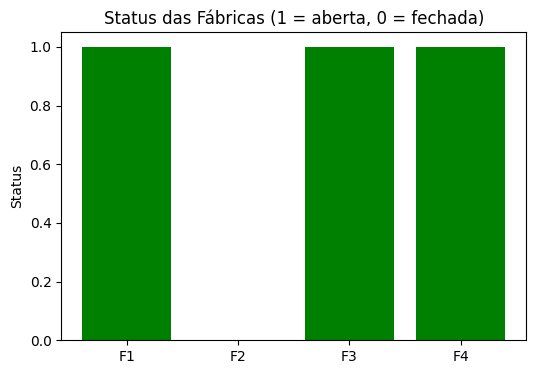

In [ ]:
import matplotlib.pyplot as plt
open_factories = [i for i in fabrics if y[i].x > 0.5]
status = ["Aberta" if i in open_factories else "Fechada" for i in fabrics]

plt.figure(figsize=(6,4))
plt.bar(fabrics, [y[i].x for i in fabrics], color=["green" if s=="Aberta" else "red" for s in status])
plt.title("Status das Fábricas (1 = aberta, 0 = fechada)")
plt.ylabel("Status")
plt.show()


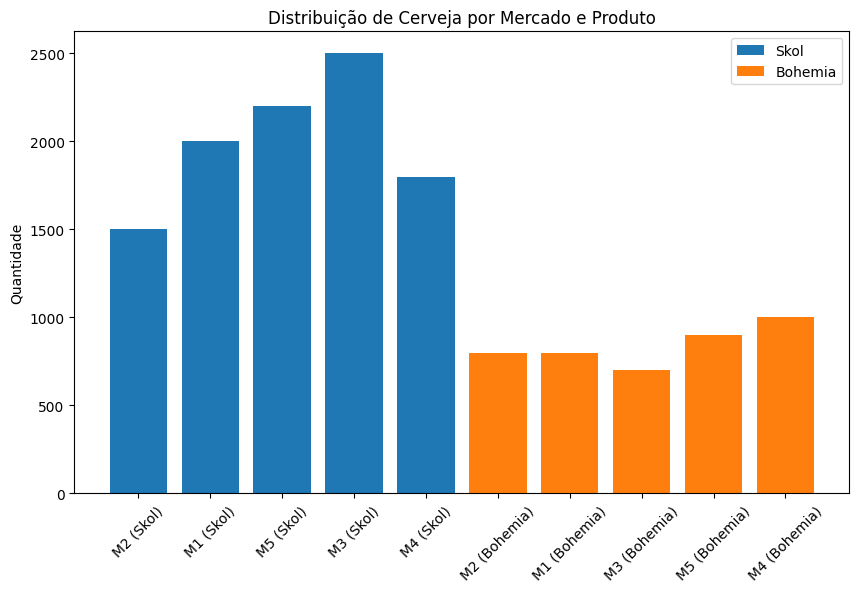

In [ ]:

flows = []
for i in fabrics:
    for j in markets:
        for p in products:
            if x[i,j,p].x > 1e-6:
                flows.append((i,j,p,x[i,j,p].x))

df_flows = pd.DataFrame(flows, columns=["Fábrica","Mercado","Produto","Quantidade"])

plt.figure(figsize=(10,6))
for produto in products:
    subset = df_flows[df_flows["Produto"]==produto]
    plt.bar(subset["Mercado"] + " ("+subset["Produto"]+")", subset["Quantidade"], label=produto)

plt.title("Distribuição de Cerveja por Mercado e Produto")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Conclusão da Modelagem: Empresa de Cerveja

A partir da solução ótima encontrada, alguns pontos merecem destaque:

- **Custo ótimo obtido**: o modelo forneceu um valor mínimo considerando os custos fixos de abertura das fábricas e os custos variáveis de transporte tanto para *Skol* quanto para *Bohemia*. Esse resultado permite comparar cenários e avaliar trade-offs de maneira objetiva.

- **Fábricas abertas**: foram abertas aquelas que apresentam o melhor equilíbrio entre custo fixo e proximidade dos mercados, otimizando o transporte, principalmente da *Bohemia*, que possui custo unitário mais elevado. Isso sugere que mercados mais distantes, com demanda por *Bohemia*, podem justificar a abertura de uma nova planta nas proximidades em vez de longos fretes.

- **Distribuição por produto**:
  - A *Skol*, produto com transporte mais barato, tende a ser atendida por fábricas com maior capacidade instalada e localização centralizada.
  - A *Bohemia*, com custo de transporte 50 % maior (fator 3 versus 2 para distância), impacta diretamente na decisão de onde abrir fábricas. Isso evidencia a importância de considerar diferenças entre produtos na análise de localização.

- **Trade-offs claros**:
  - **Abrir nova fábrica**: aumenta custo fixo, mas pode reduzir significativamente o custo de transporte de bebidas mais caras (como *Bohemia*).
  - **Transportar de fábricas distantes**: evita custo fixo adicional, mas eleva custo unitário de transporte, podendo ser menos eficiente dependendo da distância e volumes.

No geral, o modelo evidencia que, quando há diferença relevante nos custos de transporte entre produtos, incluir variáveis que capturem essa distinção (como no nosso caso com *Skol* e *Bohemia*) permite decisões mais racionais e potencialmente menos onerosas para a rede logística da empresa.


Portanto, esse modelo da empresa de cerveja alinha-se com vários aspectos destacados no artigo:
  - É um **modelo capacitado** e de **múltiplos produtos**, refletindo a diversidade de formulações revisadas.
  - Incorporamos **diferenças de custo entre produtos**, semelhantes à abordagem multi-objetivo ou multicritério apontada.
  - Seria possível estender o modelo para incluir **aspectos de sustentabilidade** ou incertezas na demanda, conforme as tendências emergentes.